# RAG Agent using LangGraph
<img src="RAG.jpg" width=500/>

## Table of Contents

1. **Load LLM (Groq - LlaMa-3.3 70B)**
2. **Create Retriever Tool**
    * **Load Data**
    * **Insert Data in Vector Store**
    * **Retriever Tool from Vector Store**
4. **Bind Retriever with LLM**
5. **Define RAG Agent**
6. **Query Agent**

In [1]:
from dotenv import find_dotenv, load_dotenv
import os

load_dotenv(find_dotenv())

groq_api_key = os.environ["GROQ_API_KEY"]

## 1. Load LLM

* **pip install langchain-groq**

In [2]:
from langchain_groq import ChatGroq

llama3 = ChatGroq(api_key=groq_api_key, model="llama-3.3-70b-versatile")

llama3

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x737b05591760>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x737b05592900>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [3]:
llama3.invoke("Hello, How are you Llama 3.3?")

AIMessage(content="Hello! I'm doing well, thanks for asking. I'm a large language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to assist you with any questions or tasks you may have. I'm Llama 3, an AI designed to provide information and help with a wide range of topics. How can I help you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 47, 'total_tokens': 126, 'completion_time': 0.287272727, 'prompt_time': 0.00231775, 'queue_time': 0.057301929, 'total_time': 0.289590477}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9a8b91ba77', 'finish_reason': 'stop', 'logprobs': None}, id='run-f4f69c5f-1eb4-4838-acc4-2cc9875127f2-0', usage_metadata={'input_tokens': 47, 'output_tokens': 79, 'total_tokens': 126})

## 2. Create Retriever Tool

### 2.1 Load Data

* **pip install pypdf**

In [4]:
from langchain_community.document_loaders import PyPDFLoader

pdf_loader = PyPDFLoader("Apple-10-k-2023.pdf")

pages = pdf_loader.load()

len(pages)

80

In [5]:
pages[3]

Document(metadata={'producer': 'Wdesk Fidelity Content Translations Version 009.001.026', 'creator': 'Workiva', 'creationdate': '2023-11-02T15:17:08+00:00', 'moddate': '2023-11-02T15:17:08+00:00', 'title': '10-K 2023, 09.30.2023-2023-11-02-08-16', 'author': 'anonymous', 'source': 'Apple-10-k-2023.pdf', 'total_pages': 80, 'page': 3, 'page_label': '4'}, page_content='This Annual Report on Form 10-K (“Form 10-K”) contains forward-looking statements, within the meaning of the Private \nSecurities Litigation Reform Act of 1995, that involve risks and uncertainties. Many of the forward-looking statements are \nlocated in Part I, Item 1 of this Form 10-K under the heading “Business” and Part II, Item 7 of this Form 10-K under the heading \n“Management’s Discussion and Analysis of Financial Condition and Results of Operations.” Forward-looking statements \nprovide current expectations of future events based on certain assumptions and include any statement that does not directly \nrelate to any

In [6]:
from langchain.text_splitter import SentenceTransformersTokenTextSplitter

text_splitter  = SentenceTransformersTokenTextSplitter(
    model_name="sentence-transformers/all-distilroberta-v1",
    chunk_overlap=50,
)

split_pages = text_splitter.split_documents(pages)

print(f"Total chunks: {len(split_pages)}")

Total chunks: 170


### 2.2 Load Docs in Vector Store

* **pip install chromadb**
* **pip install langchain-chroma**

In [7]:
import chromadb
from langchain_chroma import Chroma
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

### 1. Create Client
persistent_client = chromadb.PersistentClient(path="./apple_10k_2023")
### 2. Define Embedding Function
distil_roberta = SentenceTransformerEmbeddingFunction(model_name="all-distilroberta-v1")
### 3. Create Collection
collection = persistent_client.create_collection(
    name="apple_10k_2023", 
    metadata={
        "title": "Apple 10k 2023", 
        "description": "This store contains embeddings of Apple 10 report for 2023."},
    embedding_function=distil_roberta,                                             
    get_or_create=True
)
### 4. Add Docs to Collection
collection.add(
    documents=[doc.page_content for doc in split_pages],
    ids=[f"Chunk-{idx}" for idx, doc in enumerate(split_pages, start=1)],
    metadatas=[doc.metadata for doc in split_pages]
)

### 2.3 Retriever Tool from Vector Store

In [8]:
from langchain_core.tools import tool, StructuredTool

@tool
def retriever_tool(query):
    """
    search_apple_10k_report:
    Search and return financial information about Apple from 10k Report filed for year 2023.
    """
    results = collection.query(
        query_texts=[query,],
        n_results=5
    )
    
    return "\n\n\n".join(results["documents"][0])

tools = [retriever_tool]

In [9]:
retriever_tool.invoke("revenue of apple")

'Apple Inc.\nCONSOLIDATED STATEMENTS OF OPERATIONS\n(In millions, except number of shares, which are reflected in thousands, and per-share amounts)\nYears ended\nSeptember 30,\n2023\nSeptember 24,\n2022\nSeptember 25,\n2021\nNet sales:\n   Products $ 298,085 $ 316,199 $ 297,392 \n   Services  85,200  78,129  68,425 \nTotal net sales  383,285  394,328  365,817 \nCost of sales:\n   Products  189,282  201,471  192,266 \n   Services  24,855  22,075  20,715 \nTotal cost of sales  214,137  223,546  212,981 \nGross margin  169,148  170,782  152,836 \nOperating expenses:\nResearch and development  29,915  26,251  21,914 \nSelling, general and administrative  24,932  25,094  21,973 \nTotal operating expenses  54,847  51,345  43,887 \nOperating income  114,301  119,437  108,949 \nOther income/(expense), net  (565)  (334)  258 \nIncome before provision for income taxes  113,736  119,103  109,207 \nProvision for income taxes  16,741  19,300  14,527 \nNet income $ 96,995 $ 99,803 $ 94,680 \nEarning

## 3. Bind with Tools

In [10]:
llama3_with_tools = llama3.bind_tools(tools, tool_choice="auto") 
# "auto" to automatically determine which function to call with the option to not call any function
# "any" to enforce that some function is called

In [11]:
ai_msg = llama3_with_tools.invoke("Whatzzzz up?")

print(ai_msg.content)
print(ai_msg.tool_calls)

It seems like you're trying to start a casual conversation. I'm here to help with any questions or provide information on a wide range of topics. How can I assist you today?
[]


In [12]:
ai_msg = llama3_with_tools.invoke("Whats Revenue of Apple?")

print(ai_msg.content)
print(ai_msg.tool_calls)


[{'name': 'retriever_tool', 'args': {'query': 'Revenue of Apple'}, 'id': 'call_5a5p', 'type': 'tool_call'}]


## 4. Define RAG Agent

<img src="RAG-Agent.png" width=300/>

In [13]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

class AgentState(TypedDict): ## Agent's current state, it can be history of messsages and other attributes you want to maintain
    messages: Annotated[list[AnyMessage], operator.add]   ## {'messages': []}
        
class RAGAgent:
    
    def __init__(self, model, tools, system="You are a helpful assistant."):
        self.system = system
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools, tool_choice="auto")
        
        graph = StateGraph(AgentState)  ## Current Agent State will be available at each node of Graph.
        graph.add_node("llama3", self.call_llm)
        graph.add_node("retriever", self.take_action)
        graph.add_conditional_edges(
            "llama3",
            self.exists_action,
            {True: "retriever", False: END}
        )
        graph.add_edge("retriever", "llama3")
        graph.set_entry_point("llama3")
        self.graph = graph.compile()
        
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_llm(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]} ## AIMessage

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling Tool: {t}")
            if not t['name'] in self.tools:  # check for bad tool name from LLM
                print(f"\n Tool: {t} does not exist.")
                result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Tools Execution Complete. Back to the model!")
        return {'messages': results} ## [ToolMessage, ToolMessage, ...]

In [14]:
prompt = """
You are a smart AI finance assistant. Use the retriever tool available to answer questions.
You are allowed to make multiple calls (either together or in sequence).
If you need to look up some information before asking a follow up question, you are allowed to do that!.
"""

agent = RAGAgent(llama3, tools, system=prompt)

* **pip install pygraphviz**

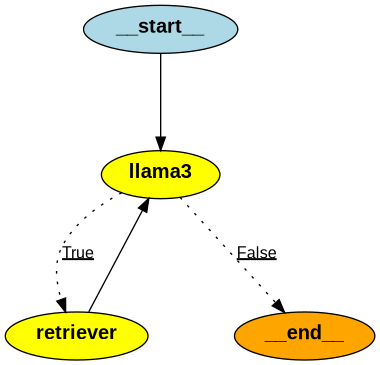

In [17]:
from IPython.display import Image

Image(agent.graph.get_graph().draw_png())

## 5. Query Agent

In [18]:
messages = [HumanMessage(content="Hello, How are you?")]

result = agent.graph.invoke({"messages": messages})

In [19]:
result['messages'][-1].content

"I'm doing well, thank you for asking. Is there something I can help you with, or would you like to know something about Apple's financials from their 10k report for 2023?"

In [20]:
messages = [HumanMessage(content="What is total revenue of Apple?")]

result = agent.graph.invoke({"messages": messages})

Calling Tool: {'name': 'retriever_tool', 'args': {'query': 'total revenue of Apple from 10k report 2023'}, 'id': 'call_9ny7', 'type': 'tool_call'}
Tools Execution Complete. Back to the model!


In [21]:
result

{'messages': [HumanMessage(content='What is total revenue of Apple?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9ny7', 'function': {'arguments': '{"query": "total revenue of Apple from 10k report 2023"}', 'name': 'retriever_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 316, 'total_tokens': 343, 'completion_time': 0.098181818, 'prompt_time': 0.019900915, 'queue_time': 0.059314096999999996, 'total_time': 0.118082733}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-677237a9-f51f-4b07-9cf4-9a14168e6209-0', tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'total revenue of Apple from 10k report 2023'}, 'id': 'call_9ny7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 316, 'output_tokens': 27, 'total_tokens': 343}),
  ToolMessage(content='914 \nPercenta

In [22]:
result['messages'][-1].content

'The total revenue of Apple is $383,285 million.'

In [23]:
messages = [HumanMessage(content="What is revenue of Apple by regions?")]

result = agent.graph.invoke({"messages": messages})

Calling Tool: {'name': 'retriever_tool', 'args': {'query': 'Apple revenue by region 2023'}, 'id': 'call_shy3', 'type': 'tool_call'}
Tools Execution Complete. Back to the model!


In [24]:
print(result['messages'][-1].content)

The revenue of Apple by region is as follows:

- U.S.: $138,573 million
- China: $72,559 million
- Other countries: $172,153 million

Total net sales: $383,285 million.


In [25]:
messages = [HumanMessage(content="Tell me about List of services provided by Apple.")]

result = agent.graph.invoke({"messages": messages})

Calling Tool: {'name': 'retriever_tool', 'args': {'query': 'List of services provided by Apple'}, 'id': 'call_2zjc', 'type': 'tool_call'}
Tools Execution Complete. Back to the model!


In [26]:
print(result['messages'][-1].content)

The list of services provided by Apple includes:

1. Advertising services
2. AppleCare (fee-based service and support products)
3. Cloud Services (store and keep customers' content up-to-date and available across multiple Apple devices and Windows personal computers)
4. Digital Content (including the App Store, Apple Arcade, Apple Fitness+, Apple Music, Apple News+, and Apple TV+)
5. Payment Services (including Apple Card and Apple Pay)

These services are part of Apple's various product segments, including:

1. Americas
2. Europe
3. Greater China
4. Japan
5. Rest of Asia Pacific

Apple's products and services are sold to customers in various markets, including consumer, small and mid-sized business, education, enterprise, and government markets.


In [27]:
messages = [HumanMessage(content="Tell me about legal proceedings of apple.")]

result = agent.graph.invoke({"messages": messages})

Calling Tool: {'name': 'retriever_tool', 'args': {'query': 'legal proceedings of Apple from 10k Report filed for year 2023'}, 'id': 'call_gdmb', 'type': 'tool_call'}
Tools Execution Complete. Back to the model!
Calling Tool: {'name': 'retriever_tool', 'args': {'query': 'Apple legal proceedings'}, 'id': 'call_ej12', 'type': 'tool_call'}
Tools Execution Complete. Back to the model!


In [28]:
print(result['messages'][-1].content)

Based on the 10-K report filed for the year 2023, Apple is involved in several legal proceedings. Two notable cases are:

1. Epic Games: Epic Games filed a lawsuit against Apple alleging violations of federal and state antitrust laws and California's unfair competition law based on Apple's operation of its App Store. The District Court ruled in favor of Apple on nine out of ten counts, but found that certain provisions of Apple's App Store Review Guidelines violate California's unfair competition law. The court issued an injunction enjoining Apple from prohibiting developers from including external links that direct customers to purchasing mechanisms other than Apple's in-app purchasing. The injunction applies to apps on the U.S. storefront of the iOS and iPadOS App Store.

2. Masimo: Masimo Corporation and Cercacor Laboratories, Inc. filed a complaint before the U.S. International Trade Commission (ITC) alleging infringement.

These legal proceedings may have a material adverse impact

In [29]:
messages = [HumanMessage(content="What is net sales of Apple by segments?")]

result = agent.graph.invoke({"messages": messages})

Calling Tool: {'name': 'retriever_tool', 'args': {'query': 'Apple net sales by segments 2023'}, 'id': 'call_z3m9', 'type': 'tool_call'}
Tools Execution Complete. Back to the model!


In [30]:
print(result['messages'][-1].content)

Net sales of Apple by segments for the year 2023 are:

- iPhone: $200,583 million
- Mac: $29,357 million
- iPad: $28,300 million
- Wearables, Home and Accessories: $39,845 million
- Services: $85,200 million

Total net sales for 2023: $383,285 million


In [31]:
messages = [HumanMessage(content="What is net sales of Apple by products & services?")]

result = agent.graph.invoke({"messages": messages})

Calling Tool: {'name': 'retriever_tool', 'args': {'query': 'Apple net sales by products and services from 10k report 2023'}, 'id': 'call_75y4', 'type': 'tool_call'}
Tools Execution Complete. Back to the model!


In [32]:
print(result['messages'][-1].content)

The net sales of Apple by products and services are as follows:

- Products: $298,085 million
  - iPhone: $200,583 million
  - Mac: $29,357 million
  - iPad: $28,300 million
  - Wearables, Home and Accessories: $39,845 million

- Services: $85,200 million

Total net sales: $383,285 million


In [33]:
messages = [HumanMessage(content="Tell me about operating expenses of apple")]

result = agent.graph.invoke({"messages": messages})

Calling Tool: {'name': 'retriever_tool', 'args': {'query': 'operating expenses of Apple from 10k Report filed for year 2023'}, 'id': 'call_f53y', 'type': 'tool_call'}
Tools Execution Complete. Back to the model!
Calling Tool: {'name': 'retriever_tool', 'args': {'query': 'apple 10k report 2023 operating expenses'}, 'id': 'call_97j9', 'type': 'tool_call'}
Tools Execution Complete. Back to the model!
Calling Tool: {'name': 'retriever_tool', 'args': {'query': 'operating expenses apple 10k 2023'}, 'id': 'call_fxnh', 'type': 'tool_call'}
Tools Execution Complete. Back to the model!


In [34]:
print(result['messages'][-1].content)

The total operating expenses for Apple in 2023 were $54,847 million, which is a 7% increase from 2022. The research and development expense was $29,915 million, and the selling, general, and administrative expense was $24,932 million. The total operating income was $114,301 million.


In [35]:
messages = [HumanMessage(content="Tell me about apple's assets")]

result = agent.graph.invoke({"messages": messages})

Calling Tool: {'name': 'retriever_tool', 'args': {'query': 'apple assets 10k report 2023'}, 'id': 'call_j2jj', 'type': 'tool_call'}
Tools Execution Complete. Back to the model!
Calling Tool: {'name': 'retriever_tool', 'args': {'query': 'apple total assets 10k report 2023'}, 'id': 'call_ga04', 'type': 'tool_call'}
Tools Execution Complete. Back to the model!


In [36]:
print(result['messages'][-1].content)

As of September 30, 2023, Apple's total assets were $352,583 million.
